In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
from tkinter import filedialog
import spotipy as sp
import spotipy.util as util
from spotipy import oauth2
from spotipy.oauth2 import SpotifyClientCredentials
%config InlineBackend.figure_format ='retina'
import random
from functools import reduce

In [2]:
client_id = '14498f1851cb44baa6af1641d5d1b650' #these are my (Jacob's) credentials
client_secret = 'f68c94b6e4d445e9a005062e95e0be8d'
spotify = sp.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id,client_secret))

In [3]:
number = input('How many streaming files do you have? ') #this cell is designed to make the notebook user-friendly
try: #by shift-entering through each cell & inputting a valid data file, anyone can read out their own
    number = int(number) #Spotify Wrapped, whenever
    print('Please select your files below.')
except:
    print('Please input a positive integer.')
    print('Run this cell again.')

How many streaming files do you have? 2
Please select your files below.


In [4]:
files = {} #this cell continues the previous cell
for i in range(0,number):
    root = tk.Tk()
    root.withdraw()
    files['File{0}'.format(i)] = filedialog.askopenfilenames() #this specific line opens the file-opener to select

In [5]:
streams = {} #this cell reads & cleans data, putting it all into a dictionary
holdholder = []
for i in files:
    for j in files[i]:
        holder = j.split('/')
        holdholder.append(holder[-1])
        streams['Stream{0}'.format(i)] = pd.read_json(holder[-1])

In [6]:
artists = {} #this cell separates data into songs & artists, also collecting time played & number of times played
songs = {}
timevals = []
for i in streams:
    ruco = 0
    for k in streams[i]['trackName']:
        if k not in songs:
            songs[k] = [1,streams[i]['msPlayed'][ruco],streams[i]['artistName'][ruco]]
        if k in songs:
            songs[k][0] += 1
            songs[k][1] += streams[i]['msPlayed'][ruco]
        ruco += 1
            
    for l in streams[i]['artistName']:
        if l not in artists:
            artists[l] = 1
        if l in artists:
            artists[l] += 1
    
    for m in streams[i]['msPlayed']:
        timevals.append(m)

In [7]:
songs_sort = sorted(songs.items(),key = lambda kv: kv[1],reverse = True) #sorting data
artists_sort = sorted(artists.items(),key = lambda kv: kv[1],reverse = True)

In [8]:
def get_artist(name):
    '''
    This function finds an artist's data on Spotify & returns it
    '''
    results = spotify.search(q='artist:'+name,type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        return items[0]
    else:
        return None

In [9]:
def get_100_favorite_artists(filename):
    '''
    This function finds the top 100 artists for a user based on data file
    '''
    artists = {}
    stream = pd.read_json(filename)

    for j in stream['artistName']:
        if j not in artists:
            artists[j] = 1
        elif j in artists:
            artists[j] += 1
    art_lists = sorted(artists.items(),key = lambda kv: kv[1],reverse = True)
    
    artist_list = []
    for i in art_lists[:100]:
        artist_list.append(i[0])
        
    return artist_list

In [10]:
def get_track_name_time_artist(filename):
    '''
    This function determines the tracks a user played alongside time played & artist
    '''
    tracks = {}
    stream = pd.read_json(filename)

    for i in range(len(stream)):
        name = stream['trackName'][i]
        time = stream['msPlayed'][i]
        artist = stream['artistName'][i]
        if name not in tracks:
            tracks[name] = [time,artist]
        elif name in tracks:
            tracks[name][0] += time
    tracks = sorted(tracks.items(),key = lambda kv: kv[1],reverse = True)
    df = pd.DataFrame(tracks, columns =['track_names','time_artist'])

        
    return tracks,df

In [11]:
def set_up_nineD(df):
    '''
    This function reads in the 9 characteristics of a given song & aids in recommending selections
    at the end
    '''
    N = len(df)
    nineD = np.zeros([N,9])
    for i in range(N):
        nineD[i,0] = df['danceability'][i]
        nineD[i,1] = df['energy'][i]
        nineD[i,2] = df['loudness'][i]
        nineD[i,3] = df['speechiness'][i]
        nineD[i,4] = df['acousticness'][i]
        nineD[i,5] = df['instrumentalness'][i]
        nineD[i,6] = df['liveness'][i]
        nineD[i,7] = df['valence'][i]
        nineD[i,8] = df['tempo'][i]
    return nineD

In [12]:
from math import *
def distance(p1,p2):
    '''Returns the distance betwen two points'''
    return sqrt((p1[0] - p2[0])**2 + 
                (p1[1] - p2[1])**2 +
                (p1[2] - p2[2])**2 +
                (p1[3] - p2[3])**2 +
                (p1[4] - p2[4])**2 +
                (p1[5] - p2[5])**2 +
                (p1[6] - p2[6])**2 +
                (p1[7] - p2[7])**2 +
                (p1[8] - p2[8])**2)

In [13]:
def knn (Center,nineD,k=3):
    '''
    This function determines the nearest neighbor of a given point
    '''
    N = len(nineD)
    dist_list = []
    for i in range(N):
        dist = distance(Center,nineD[i])
        dist_list.append(dist)
    
    min_value = []
    min_index = []
    for j in range(k):
        min_val = sorted(dist_list)[j]
        min_value.append(min_val)
        
        min_ind = dist_list.index(min_val)
        min_index.append(min_ind)
    return min_value , min_index

In [14]:
def merge_files(stream, *stream2):
    '''
    This file can aid in the merging of files for analysis
    It combines any number of dataframes into an existing, base frame
    '''
    for i in stream2:
        big_df = stream.append((i), ignore_index = True)
    return big_df

In [15]:
genres = {} #This cell determines the genres for a user's top artists
for i in artists:
    try:
        holder = get_artist(i)['genres']
        for k in holder:
            if k not in genres:
                genres[k] = 1
            if k in genres:
                genres[k] += 1
    except:
        pass

In [16]:
genres_sort = sorted(genres.items(),key = lambda kv: kv[1],reverse = True) #This cell sorts the top genres a user
top10genre = genres_sort[:10] #listens to & returns the top 10

In [17]:
tracktracker = {}
for i in holdholder:
    tracks,tracks_time = get_track_name_time_artist(i)
    tracktracker[i] = [tracks,tracks_time]
tracks_time = tracks_time.head(2000)
#tracks_time

In [18]:
all_songs = pd.read_csv('tracks.csv') #this cell places a user's listened tracks into a dataframe in order to
all_songs = all_songs.drop(columns = ['duration_ms','explicit','id','id_artists','mode']) #recommend new tracks
all_songs = all_songs.drop_duplicates(subset = ['name', 'artists'],
                                     keep = 'last').reset_index(drop = True)

In [19]:
final_all_songs = all_songs.sort_values('popularity', ascending = False) #this cell masks previously listened tracks
names = tracks_time['track_names'].values.tolist() #against a database of music going back 100 years

In [20]:
data_all = pd.DataFrame() #this cell formally masks
for i in range(len(names)):
    name = names[i]
    artist = tracks_time['time_artist'][i][1]
    formatted = '[\''+artist+'\']'
    
    mask1 = final_all_songs['name'] == name
    mask2 = final_all_songs['artists'] == formatted
    data_all = data_all.append(final_all_songs[mask1&mask2])

In [21]:
#data_all #this cell could provide a dataframe of the mask

In [22]:
print(data_all.describe().loc['mean']) #this cell cleans up song values, used in recommendations
#print(data_all.describe().loc['mean'].values.tolist())
Center = data_all.describe().loc['mean'].values.tolist()
del Center[0] #pop
del Center[2] #key
#del Center[8] #tempo, if uncomment, have to change below to 8 too.
del Center[9] #time_sig
#print(Center)

popularity           63.606880
danceability          0.638678
energy                0.633633
key                   5.187961
loudness             -6.676612
speechiness           0.097130
acousticness          0.225178
instrumentalness      0.039761
liveness              0.183167
valence               0.485758
tempo               121.733711
time_signature        3.958231
Name: mean, dtype: float64


In [23]:
small_all = final_all_songs.head(100000) #a continuation of the previous cell
small_all = small_all.reset_index()
nineD = set_up_nineD(small_all)
zoinks = 10 #name is irrelevant
min_value , min_index = knn(Center,nineD,k=zoinks)

In [24]:
recommendation_df = small_all.loc[min_index] #the recommendation dataframe, masked from the total database
recommendation_df = recommendation_df.reset_index()
#recommendation_df

In [25]:
mssum = 0
for i in timevals:
    mssum += i

ssum = mssum*.001 #converting milliseconds to minutes
msum = ssum/60
msumrd = round(msum,2)
top5songs = [] #top 5 most played tracks
t5sart = [] #top 5 most played artists
helpcount = 0

for j in songs_sort:
    if helpcount < 5:
        top5songs.append(j[0])
        t5sart.append(j[1][-1])
    helpcount += 1

In [26]:
print('Congratulations on',msumrd,'minutes of listening!')
print()
print('This past year, your top 5 songs were:')
print(top5songs[0],'by',t5sart[0])
print(top5songs[1],'by',t5sart[1])
print(top5songs[2],'by',t5sart[2])
print(top5songs[3],'by',t5sart[3])
print(top5songs[4],'by',t5sart[4])
print()
print('This past year, your top 10 artists were:')
print(artists_sort[0][0],'who you listened to',artists_sort[0][1],'times!')
print(artists_sort[1][0],'who you listened to',artists_sort[1][1],'times!')
print(artists_sort[2][0],'who you listened to',artists_sort[2][1],'times!')
print(artists_sort[3][0],'who you listened to',artists_sort[3][1],'times!')
print(artists_sort[4][0],'who you listened to',artists_sort[4][1],'times!')
print(artists_sort[5][0],'who you listened to',artists_sort[5][1],'times!')
print(artists_sort[6][0],'who you listened to',artists_sort[6][1],'times!')
print(artists_sort[7][0],'who you listened to',artists_sort[7][1],'times!')
print(artists_sort[8][0],'who you listened to',artists_sort[8][1],'times!')
print(artists_sort[9][0],'who you listened to',artists_sort[9][1],'times!')
print()
print('This past year, your top genres were:')
print(top10genre[0][0].upper())
print(top10genre[1][0].upper())
print(top10genre[2][0].upper())

Congratulations on 36646.21 minutes of listening!

This past year, your top 5 songs were:
She's My Collar (feat. Kali Uchis) by Gorillaz
Pursuit Of Happiness (Nightmare) by Kid Cudi
Voyager by Daft Punk
Aria Math by C418
Who's Been Sleeping In My Bed by Barry Manilow

This past year, your top 10 artists were:
Gorillaz who you listened to 692 times!
Daft Punk who you listened to 380 times!
Kanye West who you listened to 358 times!
The Neighbourhood who you listened to 331 times!
The Beatles who you listened to 277 times!
Pitbull who you listened to 238 times!
C418 who you listened to 211 times!
Greta Van Fleet who you listened to 207 times!
Arctic Monkeys who you listened to 194 times!
The Killers who you listened to 179 times!

This past year, your top genres were:
POP
ROCK
MODERN ROCK


In [27]:
print("Going into the next year, here's some music we think you'll love!")
print()
print('Song Title',"['Band Name']")
print('-----------------------------------------------------------------------------------------------')
print()
for i in range(zoinks):
    print(recommendation_df['name'][i],recommendation_df['artists'][i],'\n')

Going into the next year, here's some music we think you'll love!

Song Title ['Band Name']
-----------------------------------------------------------------------------------------------

I Think I'm In Love ['Kat Dahlia'] 

Roscoe - Beyond the Wizard's Sleeve Remix ['Midlake', 'Beyond The Wizards Sleeve'] 

Back on My Feet Again ['The Babys'] 

Carry On (from the Original Motion Picture "POKÉMON Detective Pikachu") ['Kygo', 'Rita Ora'] 

Knocking At Your Back Door ['Deep Purple'] 

Alles auf Rot ['Capo'] 

Blue & Grey ['BTS'] 

Strange Days ['The Doors'] 

La déclaration d'amour - Remasterisé en 2004 ['France Gall'] 

Spirit in the Sky ['KEiiNO'] 



Text(0.5, 1.0, 'Top Listening Songs, Visualised')

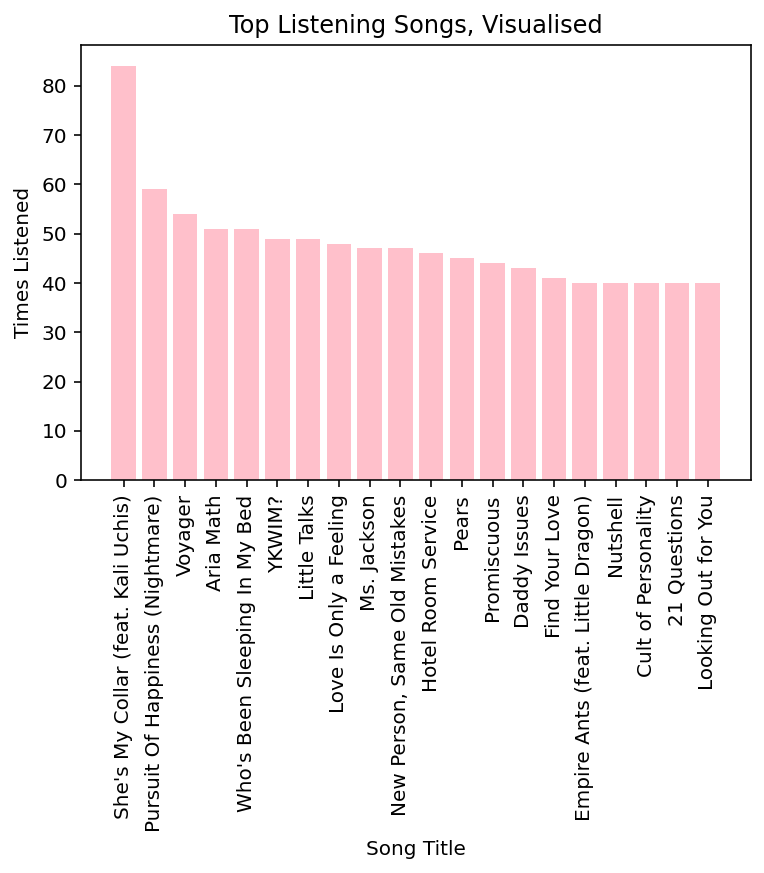

In [28]:
x = []
y = []
for i in range(20):
    x.append(songs_sort[i][0])
    y.append(songs_sort[i][1][0])
plt.bar(x,y,color = 'pink')
plt.xticks(rotation=90)
plt.xlabel('Song Title')
plt.ylabel('Times Listened')
plt.title('Top Listening Songs, Visualised')